In [14]:
from jax import numpy as jnp
from jax import jacfwd, jacrev, jit, vmap, lax, make_jaxpr
from jax import random as jr
from jax import tree_util as jtu
import jax
from functools import partial
import tensorflow

import gaussfiltax.utils as utils
import gaussfiltax.containers as containers
from tensorflow_probability.substrates.jax.distributions import MultivariateNormalFullCovariance as MVN
import time
import gaussfiltax.inference as gf
import gaussfiltax.particlefilt as pf
from gaussfiltax.models import ParamsNLSSM, NonlinearGaussianSSM, NonlinearSSM, ParamsBPF

import matplotlib.pyplot as plt
import matplotlib_inline
from IPython.display import set_matplotlib_formats
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

## Models and simulations

In [15]:
# Parameters
state_dim = 3
state_noise_dim = 3
emission_dim = 3
emission_noise_dim = 3
seq_length = 100
mu0 = 1.0 * jnp.zeros(state_dim)
q0 = jnp.zeros(state_noise_dim)
r0 = jnp.ones(emission_noise_dim)
Sigma0 = 1.0 * jnp.eye(state_dim)
Q = 20.0 * jnp.eye(state_noise_dim)
R = 1.0 * jnp.eye(emission_noise_dim)

# ICASSP
f1 = lambda x, q, u: (1-u) * x / 2.  + u * jnp.sin(10 * x) + q
g1 = lambda x, r, u:  1.0 * jnp.dot(x, x) + r
def g1lp(x,y,u):
    return MVN(loc = g1(x, 0.0, u), covariance_matrix = R).log_prob(y)


# Lorenz 63
def lorentz_63(x, sigma=10, rho=28, beta=2.667, dt=0.01):
    dx = dt * sigma * (x[1] - x[0])
    dy = dt * (x[0] * rho - x[1] - x[0] *x[2]) 
    dz = dt * (x[0] * x[1] - beta * x[2])
    return jnp.array([dx+x[0], dy+x[1], dz+x[2]])
f63 = lambda x, q, u: lorentz_63(x) + q

# Lorentz 96
alpha = 1.0
beta = 1.0
gamma = 8.0
dt = 0.01
H = jnp.zeros((emission_dim,state_dim))
for row in range(emission_dim):
    col = 2*row
    H = H.at[row,col].set(1.0)
CP = lambda n: jnp.block([[jnp.zeros((1,n-1)), 1.0 ],[jnp.eye(n-1), jnp.zeros((n-1,1))]])
A = CP(state_dim)
B = jnp.power(A, state_dim-1) - jnp.power(A, 2)
f96 = lambda x, q, u: x + dt * (alpha * jnp.multiply(A @ x, B @ x) - beta * x + gamma * jnp.ones(state_dim)) + q
g96 = lambda x, r, u: H @ x + r
def g96lp(x,y,u):
  return MVN(loc = g96(x, 0.0, u), covariance_matrix = R).log_prob(y)

# stochastic growth model
f3 = lambda x, q, u: x / 2. + 25. * x / (1 + jnp.power(x, 2)) * u + q
g3 = lambda x, r, u: 0.8 * x + r
def g3lp(x,y,u):
    return MVN(loc = g3(x, 0.0, u), covariance_matrix = R).log_prob(y)


# Stochastic Volatility
alpha = 0.91
sigma = 1.0
beta = 0.5
fsv= lambda x, q, u: alpha * x + sigma * q
gsv = lambda x, r, u: beta * jnp.exp(x/2) * r
def svlp(x,y,u):
    return MVN(loc = gsv(x, r0, u), covariance_matrix = gsv(x, 1.0, u)**2 * R).log_prob(y)

# Linear - Stochastic Volatility
alpha = 0.91
sigma = 1.0
beta = 0.5
glsv = lambda x, r, u: u * beta * jnp.exp(x/2) * r + (1-u) * (0.8 * x + r)
def lsvlp(x,y,u):
    return MVN(loc = glsv(x, r0, u), covariance_matrix = u * beta ** 2 * jnp.exp(x) * R + (1-u) * R).log_prob(y)

# Multivariate SV
Phi = 0.8 * jnp.eye(state_dim)
fmsv = lambda x, q, u: Phi @ x +  ((1-u) + 0.3*u)*q
gmsv = lambda x, r, u:  u * 0.5 * jnp.multiply(jnp.exp(x/2), r)
def msvlp(x,y,u):
    return MVN(loc = gmsv(x, r0, u), covariance_matrix = jnp.diag(jnp.exp(x/2.0)) @ R @ jnp.diag(jnp.exp(x/2.0))).log_prob(y)

# Linear - Multivariate SV
alpha = 0.91
sigma = 1.0
beta = 0.5

H = 0.8 * jnp.eye(emission_dim,state_dim)
# for row in range(emission_dim):
#     col = 2*row
#     H = H.at[row,col].set(1.0)
# H = 0.1 * H
glmsv = lambda x, r, u: u * 0.5 * jnp.multiply(jnp.exp(x/2), r) + (1-u) * (H @ x + r)
def lmsvlp(x,y,u):
    M = u * 0.5 * jnp.diag(jnp.exp(x / 2.0)) + (1-u) * H
    return MVN(loc = glmsv(x, r0, u), covariance_matrix = M @ R @ M.T).log_prob(y)


# Inputs
# inputs = 1. * jnp.cos(0.1 * jnp.arange(seq_length))
sm = lambda x : jnp.exp(x) / (1+jnp.exp(x))
inputs = sm(jnp.arange(seq_length)-50) # off - on
# inputs = 0.0 * jnp.ones(seq_length) # on - on
# inputs = 1.0 * jnp.ones(seq_length) # on - on

In [16]:
f = fmsv
g = glmsv
glp = lmsvlp

In [17]:
# initialization
model = NonlinearSSM(state_dim, state_noise_dim, emission_dim, emission_noise_dim)
params = ParamsNLSSM(
    initial_mean=mu0,
    initial_covariance=Sigma0,
    dynamics_function=f,
    dynamics_noise_bias= q0,
    dynamics_noise_covariance=Q,
    emission_function=g,
    emission_noise_bias= r0,
    emission_noise_covariance=R,
)

# Generate synthetic data 
key, _ = jr.split(jr.PRNGKey(0))
states, emissions = model.sample(params, key, seq_length, inputs = inputs)

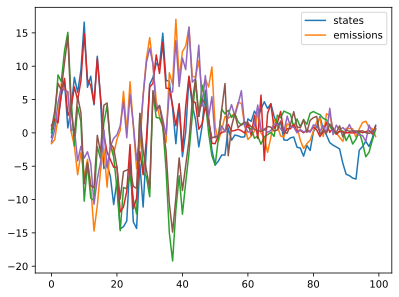

In [18]:
plt.plot(states)
plt.plot(emissions)
plt.legend(['states', 'emissions'])
plt.show()

## Inference

In [19]:
# GSF
M = 5
tin = time.time()
posterior_filtered_gsf = gf.gaussian_sum_filter(params, emissions, M, 1, inputs)
point_estimate_gsf = jnp.sum(jnp.einsum('ijk,ij->ijk', posterior_filtered_gsf.means, posterior_filtered_gsf.weights), axis=0)
tout = time.time()
print('Time taken for GSF: ', tout - tin)

# AGSF
tin = time.time()
num_components = [M, 3, 6] # has to be set correctly OW "TypeError: Cannot interpret '<function <lambda> at 0x12eae3ee0>' as a data type". Check internal containers._branch_from_node
posterior_filtered_agsf, aux_outputs = gf.augmented_gaussian_sum_filter(params, emissions, num_components, rng_key = key, opt_args = (0.8, 1/6.0), inputs=inputs)    
point_estimate_agsf = jnp.sum(jnp.einsum('ijk,ij->ijk', posterior_filtered_agsf.means, posterior_filtered_agsf.weights), axis=0)
tout = time.time()
print('Time taken for AGSF: ', tout - tin)

# BPF
tin = time.time()
num_particles = 100

params_bpf = ParamsBPF(
    initial_mean=mu0,
    initial_covariance=Sigma0,
    dynamics_function=f,
    dynamics_noise_bias= q0,
    dynamics_noise_covariance=Q,
    emission_function=g,
    emission_noise_bias= r0,
    emission_noise_covariance=R,
    emission_distribution_log_prob = glp
)

posterior_bpf = gf.bootstrap_particle_filter(params_bpf, emissions, num_particles, key, inputs)
point_estimate_bpf = jnp.sum(jnp.einsum('ijk,ij->ijk', posterior_bpf["particles"], posterior_bpf["weights"]), axis=0)
tout = time.time()
print('Time taken for BPF: ', tout - tin)

Time taken for GSF:  3.0343029499053955
Time taken for AGSF:  56.31014823913574
Time taken for BPF:  2.668910264968872


In [20]:
# Mean squared errors
gsf_mse = jnp.linalg.norm(point_estimate_gsf - states, axis = 1)
agsf_mse = jnp.linalg.norm(point_estimate_agsf - states, axis = 1)
bpf_mse = jnp.linalg.norm(point_estimate_bpf - states, axis = 1)
print('GSF MSE: ', jnp.mean(gsf_mse))
print('AGSF MSE: ', jnp.mean(agsf_mse))
print('BPF MSE: ', jnp.mean(bpf_mse))

GSF MSE:  nan
AGSF MSE:  2.7023761
BPF MSE:  2.6371644


Hessians

## Plots

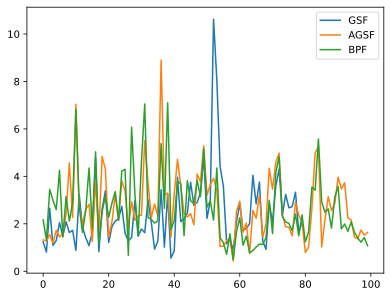

In [28]:
plt.plot(gsf_mse[0:80])
plt.plot(agsf_mse)
plt.plot(bpf_mse)
plt.legend(['GSF', 'AGSF', 'BPF'])
plt.show()

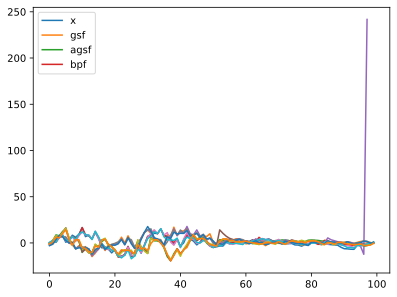

In [22]:
plt.plot(states)
plt.plot(point_estimate_gsf)
plt.plot(point_estimate_agsf)
plt.plot(point_estimate_bpf)
plt.legend(['x','gsf', 'agsf', 'bpf'])
plt.show()

### GSF

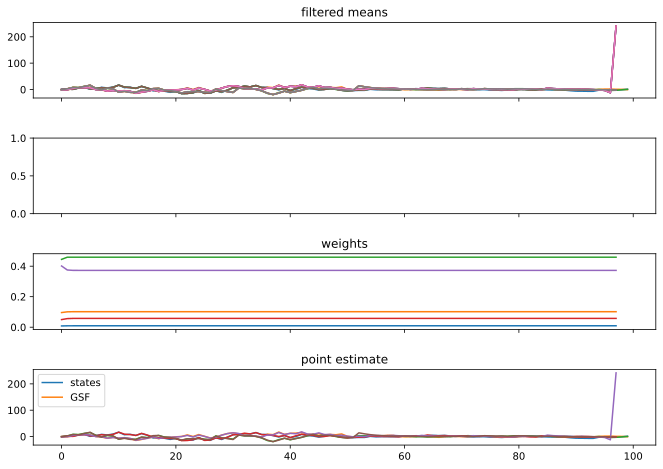

In [23]:
num_components = M

fig, axes = plt.subplots(4, 1, sharex=True, figsize=(10, 7))
fig.tight_layout(pad=3.0)
axes[0].plot(states, label="xs")
leg = ["states"]
for m in range(M):
    axes[0].plot(posterior_filtered_gsf.means[m])
    leg.append("model {}".format(m))
    axes[0].set_title("filtered means")
#axes[0].legend(leg)

if state_dim ==1:
    for m in range(M):
        axes[1].plot(posterior_filtered_gsf.covariances[m])
        axes[1].set_title("filtered covariances")

for m in range(M):
    axes[2].plot(posterior_filtered_gsf.weights[m])
    axes[2].set_title("weights")

axes[3].plot(states, label="xs")
leg = ["states", "GSF"]
axes[3].plot(point_estimate_gsf)
axes[3].legend(leg)
axes[3].set_title("point estimate")
plt.show()

### AGSF

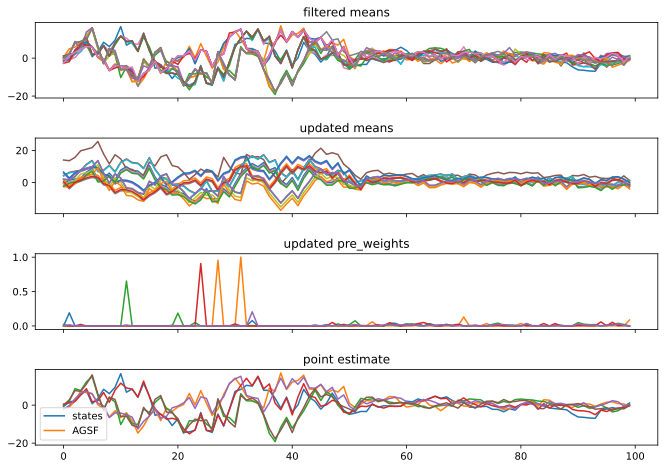

In [24]:
fig, axes = plt.subplots(4, 1, sharex=True, figsize=(10, 7))
fig.tight_layout(pad=3.0)
axes[0].plot(states, label="xs")
leg = ["states"]
for m in range(M):
    axes[0].plot(posterior_filtered_agsf.means[m])
    leg.append("model {}".format(m))
    axes[0].set_title("filtered means")

#axes[0].legend(leg)

if state_dim == 1:
    for m in range(M):
        axes[1].plot(posterior_filtered_agsf.covariances[m].squeeze())
        axes[1].set_title("filtered covariances")

else:
    for m in range(jnp.prod(num_components)):
        axes[1].plot(aux_outputs["updated_means"][:,m])
        axes[1].set_title("updated means")

for m in range(jnp.prod(jnp.array(num_components))):
        axes[2].plot(aux_outputs["pre_weights"][:,m])
        axes[2].set_title("updated pre_weights")

axes[3].plot(states, label="xs")
leg = ["states", "AGSF"]
axes[3].plot(point_estimate_agsf)
axes[3].legend(leg)
axes[3].set_title("point estimate")

plt.show()

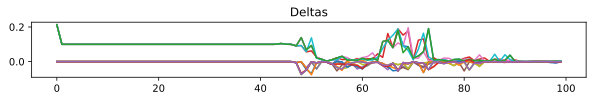

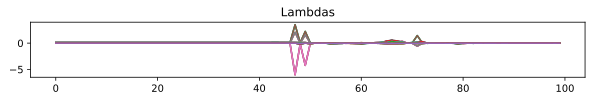

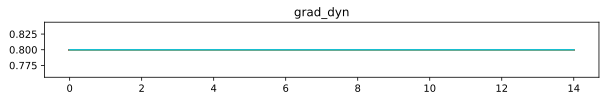

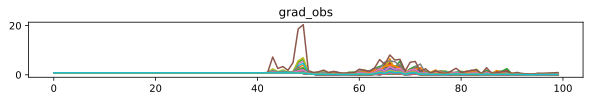

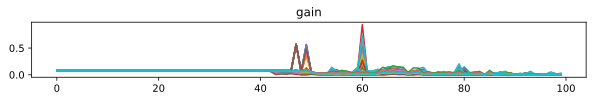

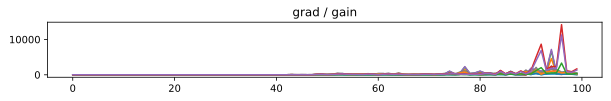

In [25]:
# plot Deltas
plt.figure(figsize=(10, 1))
for i in range(aux_outputs["Deltas"].shape[1]):
    plt.plot(aux_outputs["Deltas"][:, i, 0])
plt.title('Deltas')
plt.show()

# plot Lambdas
plt.figure(figsize=(10, 1))
for i in range(aux_outputs["Lambdas"].shape[1]):
    plt.plot(aux_outputs["Lambdas"][:, i, 0])
plt.title('Lambdas')
plt.show()

# plot grads_dyn
plt.figure(figsize=(10, 1))
for i in range(aux_outputs["grads_dyn"].shape[0]):
    plt.plot(aux_outputs["grads_dyn"][i, :, 0, 0])
plt.title('grad_dyn')
plt.show()

# plot grads_obs
plt.figure(figsize=(10, 1))
for i in range(aux_outputs["grads_obs"].shape[1]):
    plt.plot(aux_outputs["grads_obs"][:, i, 0, 0])
plt.title('grad_obs')
plt.show()

# plot gain
plt.figure(figsize=(10, 1))
for i in range(aux_outputs["gain"].shape[1]):
    plt.plot(aux_outputs["gain"][:, i, 0, 0])
plt.title('gain')
plt.show()

# plot grads_dyn / gain
plt.figure(figsize=(10, 1))
for i in range(aux_outputs["grads_dyn"].shape[1]):
    plt.plot(aux_outputs["grads_dyn"][:, i, 0, 0] / aux_outputs["gain"][:, i * 3, 0, 0])
plt.title('grad / gain')
plt.show()

### BPF

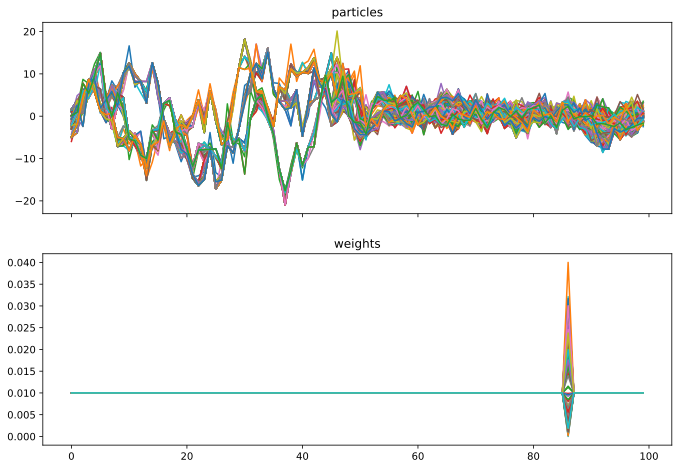

In [26]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(10, 7))
fig.tight_layout(pad=3.0)
axes[0].plot(states, label="xs")
leg = ["states"]
for m in range(num_particles):
    axes[0].plot(posterior_bpf["particles"][m])
    leg.append("model {}".format(m))
    axes[0].set_title("particles")

for m in range(num_particles):
    axes[1].plot(posterior_bpf["weights"][m])
    axes[1].set_title("weights")

plt.show()